In [1]:
import pandas as pd
import numpy as np
import sklearn
from itertools import product
from IPython.display import display
import gc
from tqdm.notebook import tqdm
import matplotlib
import catboost
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score,mean_squared_error
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.neural_network import MLPRegressor

for p in [np, pd, sklearn,catboost,lgb,matplotlib]:
    print (p.__name__, p.__version__)

numpy 1.19.2
pandas 1.1.3
sklearn 0.23.2
catboost 0.25.1
lightgbm 3.2.1
matplotlib 3.3.2


- [Competition Link](https://www.kaggle.com/c/competitive-data-science-predict-future-sales)
- [Reference modeling link](https://www.kaggle.com/dkomyagin/predict-future-sales-lightgbm-framework)
- [Reference modeling link](https://www.kaggle.com/werooring/top-3-5-lightgbm-with-feature-engineering)

Next Function is important to downcast datatype to save memory

In [2]:
def downcast(df, verbose=True):
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        dtype_name = df[col].dtype.name
        if dtype_name == 'object':
            pass
        elif dtype_name == 'bool':
            df[col] = df[col].astype('int8')
        elif dtype_name.startswith('int') or (df[col].round() == df[col]).all():
            df[col] = pd.to_numeric(df[col], downcast='integer')
        else:
            df[col] = pd.to_numeric(df[col], downcast='float')
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose:
        print('{:.1f}% compressed'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df


# Data Loading

In [3]:
sales = pd.read_csv('sales_train.csv')
items = pd.read_csv('items.csv')
item_cat = pd.read_csv('item_categories.csv')
shops = pd.read_csv('shops.csv')
test = pd.read_csv('test.csv')
sub = pd.read_csv('sample_submission.csv')


In [4]:
sub = pd.read_csv('sample_submission.csv')

In [5]:
display(sales.head(),items.head(),item_cat.head(),shops.head(),test.head())

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [6]:
sales.shape

(2935849, 6)

## Previous Value Benchmark

In [7]:
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [8]:
index_cols = ['shop_id', 'item_id', 'date_block_num']
df = sales.groupby(index_cols,as_index=False).agg({'item_cnt_day':'sum'}).rename(columns={'item_cnt_day':'item_cnt_month'})
df.drop_duplicates(index_cols,inplace=True)
df.head()

,shop_id,item_id,date_block_num,item_cnt_month
0,0,30,1,31.0
1,0,31,1,11.0
2,0,32,0,6.0
3,0,32,1,10.0
4,0,33,0,3.0


In [9]:
print('Test Set')
test.head()

Test Set


,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [10]:
x = df[df['date_block_num'] ==33]
x = pd.merge(test,x,how='left',on=['shop_id','item_id']).fillna(0)
x=x[['ID','item_cnt_month']]
x['item_cnt_month'] = x['item_cnt_month'].clip(upper=20)
x.head()

,ID,item_cnt_month
0,0,0.0
1,1,0.0
2,2,1.0
3,3,0.0
4,4,0.0


In [11]:
x.to_csv('sub_prev.csv',index=False)

# EDA - Feature Engineering

In [6]:
all_df = [sales, shops, items, item_cat, test]
for df in all_df:
    df = downcast(df)

62.5% compressed
38.6% compressed
54.2% compressed
39.9% compressed
70.8% compressed


In [7]:
# Extract data with a item_price greater than 0
sales = sales[sales['item_price'] > 0]
# Extract data with a item_priceof less than 50,000
sales = sales[sales['item_price'] < 50000]
# Extract data with item_cnt_day greater than 0
sales = sales[sales['item_cnt_day'] > 0]
# Extract data with item_cnt_day less than 1,000
sales = sales[sales['item_cnt_day'] < 1000]

In [8]:
print(shops['shop_name'][0], '||', shops['shop_name'][57])
print(shops['shop_name'][1], '||', shops['shop_name'][58])
print(shops['shop_name'][10], '||', shops['shop_name'][11])
print(shops['shop_name'][39], '||', shops['shop_name'][40])

!Якутск Орджоникидзе, 56 фран || Якутск Орджоникидзе, 56
!Якутск ТЦ "Центральный" фран || Якутск ТЦ "Центральный"
Жуковский ул. Чкалова 39м? || Жуковский ул. Чкалова 39м²
РостовНаДону ТРК "Мегацентр Горизонт" || РостовНаДону ТРК "Мегацентр Горизонт" Островной


In [9]:
#  Modify shop_id in sales_train data
sales.loc[sales['shop_id'] == 0, 'shop_id'] = 57
sales.loc[sales['shop_id'] == 1, 'shop_id'] = 58
sales.loc[sales['shop_id'] == 10, 'shop_id'] = 11
sales.loc[sales['shop_id'] == 39, 'shop_id'] = 40

#  Modify shop_id in test data
test.loc[test['shop_id'] == 0, 'shop_id'] = 57
test.loc[test['shop_id'] == 1, 'shop_id'] = 58
test.loc[test['shop_id'] == 10, 'shop_id'] = 11
test.loc[test['shop_id'] == 39, 'shop_id'] = 40

Removing non sold items and removing outliers

In [10]:
# Leaking to imporve performance
unique_test_shop_id = test['shop_id'].unique()
sales = sales[sales['shop_id'].isin(unique_test_shop_id)]

In [11]:
sales.shape

(2427354, 6)

### Extracting Features out of Shops

In [12]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


Each shop name contains the name of the city the shop in

In [13]:
shops['city'] = shops['shop_name'].apply(lambda x:x.split()[0])

In [14]:
shops['city'].unique()

array(['!Якутск', 'Адыгея', 'Балашиха', 'Волжский', 'Вологда', 'Воронеж',
       'Выездная', 'Жуковский', 'Интернет-магазин', 'Казань', 'Калуга',
       'Коломна', 'Красноярск', 'Курск', 'Москва', 'Мытищи', 'Н.Новгород',
       'Новосибирск', 'Омск', 'РостовНаДону', 'СПб', 'Самара', 'Сергиев',
       'Сургут', 'Томск', 'Тюмень', 'Уфа', 'Химки', 'Цифровой', 'Чехов',
       'Якутск', 'Ярославль'], dtype=object)

In [15]:
shops.loc[shops['city'] =='!Якутск', 'city'] = 'Якутск'

In [16]:
shops.head()

,shop_name,shop_id,city
0,"!Якутск Орджоникидзе, 56 фран",0,Якутск
1,"!Якутск ТЦ ""Центральный"" фран",1,Якутск
2,"Адыгея ТЦ ""Мега""",2,Адыгея
3,"Балашиха ТРК ""Октябрь-Киномир""",3,Балашиха
4,"Волжский ТЦ ""Волга Молл""",4,Волжский


Label Encode the cities

In [17]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
shops['city'] = le.fit_transform(shops['city'])

In [18]:
# Remove unneeded shop_name feature
shops = shops.drop('shop_name', axis=1)

shops.head()

,shop_id,city
0,0,29
1,1,29
2,2,0
3,3,1
4,4,2


### Extracting Features out of items

In [19]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [20]:
# Create the date the product was first sold as a feature
items.drop('item_name',axis=1,inplace=True)
items['first_sale_date'] = sales.groupby('item_id').agg({'date_block_num': 'min'})['date_block_num']
#items['last_sale_date'] = sales.groupby('item_id').agg({'date_block_num': 'max'})['date_block_num']

items.head()

,item_id,item_category_id,first_sale_date
0,0,40,NaN
1,1,76,15.0
2,2,40,NaN
3,3,40,NaN
4,4,40,NaN


In [21]:
items[items['first_sale_date'].isna()]

,item_id,item_category_id,first_sale_date
0,0,40,NaN
2,2,40,NaN
3,3,40,NaN
4,4,40,NaN
5,5,40,NaN
...,...,...,...
21975,21975,61,NaN
22022,22022,40,NaN
22028,22028,40,NaN
22035,22035,40,NaN


In [22]:
# Replace NaN of first_sale_date with 34
items['first_sale_date'] = items['first_sale_date'].fillna(34)

### Extracting Features out of Item_Categories

In [23]:
item_cat.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [24]:
item_cat['cat_name'] = item_cat['item_category_name'].apply(lambda x:x.split()[0])

In [25]:
item_cat['cat_name'].unique()

array(['PC', 'Аксессуары', 'Билеты', 'Доставка', 'Игровые', 'Игры',
       'Карты', 'Кино', 'Книги', 'Музыка', 'Подарки', 'Программы',
       'Служебные', 'Чистые', 'Элементы'], dtype=object)

In [26]:
item_cat['cat_name'].value_counts()

Игры          14
Книги         13
Подарки       12
Игровые        8
Аксессуары     7
Музыка         6
Программы      6
Кино           5
Карты          5
Служебные      2
Чистые         2
Билеты         1
Доставка       1
PC             1
Элементы       1
Name: cat_name, dtype: int64

In [27]:
def make_etc(x):
    if len(item_cat[item_cat['cat_name']==x]) >= 5:
        return x
    else:
        return 'etc'

# Replace with 'etc' if category count is less than 5
item_cat['cat_name'] = item_cat['cat_name'].apply(make_etc)
item_cat.head()

,item_category_name,item_category_id,cat_name
0,PC - Гарнитуры/Наушники,0,etc
1,Аксессуары - PS2,1,Аксессуары
2,Аксессуары - PS3,2,Аксессуары
3,Аксессуары - PS4,3,Аксессуары
4,Аксессуары - PSP,4,Аксессуары


In [28]:
item_cat['cat_name'] = le.fit_transform(item_cat['cat_name'])

In [29]:
item_cat.drop('item_category_name',axis=1,inplace=True)
item_cat.head()

,item_category_id,cat_name
0,0,0
1,1,1
2,2,1
3,3,1
4,4,1


In [30]:
sales.shape

(2427354, 6)

Next let's create Monthly sales Aggregates

In [31]:
# For every month we create a grid from all shops/items combinations from that month
grid = [] 
index_cols = ['date_block_num', 'shop_id', 'item_id']
for block_num in sales['date_block_num'].unique():
    cur_shops = sales[sales['date_block_num']==block_num]['shop_id'].unique()
    cur_items = sales[sales['date_block_num']==block_num]['item_id'].unique()
    grid.append(np.array(list(product([block_num], cur_shops, cur_items))))

#turn the grid into pandas dataframe
grid = pd.DataFrame(np.vstack(grid), columns = index_cols)

#get aggregated values for (shop_id, item_id, month)
gb = sales.groupby(index_cols,as_index=False).agg({'item_cnt_day':'sum','item_price':'mean'}).rename(columns={'item_cnt_day':'target','item_price':'item_price_mean'})

#join aggregated data to the grid
all_data = pd.merge(grid,gb,how='left',on=index_cols)

#sold item count 
gb = sales.groupby(index_cols,as_index=False).agg({'item_cnt_day':'count'}).rename(columns={'item_cnt_day':'item_count'})

#join aggregated data to the grid
all_data = pd.merge(all_data,gb,how='left',on=index_cols)

all_data = downcast(all_data)
del grid, gb 
gc.collect();

29.4% compressed


In [32]:
# Set test data date_block_num to 34
test['date_block_num'] = 34

# Concatenate train and test
all_data = pd.concat([all_data, test.drop('ID', axis=1)],
                     ignore_index=True,
                     keys=index_cols)
# Replace NaN with 0
all_data = all_data.fillna(0)

all_data.head()

,date_block_num,shop_id,item_id,target,item_price_mean,item_count
0,0,59,22154,1.0,999.0,1.0
1,0,59,2552,0.0,0.0,0.0
2,0,59,2554,0.0,0.0,0.0
3,0,59,2555,0.0,0.0,0.0
4,0,59,2564,0.0,0.0,0.0


Merge Features Extracted from other datasets

In [33]:
all_data = pd.merge(all_data,shops,how='left',on='shop_id')
all_data = pd.merge(all_data,items,how='left',on='item_id')
all_data = pd.merge(all_data,item_cat,how='left',on='item_category_id')

all_data = downcast(all_data)
del shops, items, item_cat
gc.collect();

52.1% compressed


In [34]:
print(all_data.shape)
all_data.head()

(8856961, 10)


,date_block_num,shop_id,item_id,target,item_price_mean,item_count,city,item_category_id,first_sale_date,cat_name
0,0,59,22154,1,999.0,1,30,37,0,5
1,0,59,2552,0,0.0,0,30,58,0,7
2,0,59,2554,0,0.0,0,30,58,0,7
3,0,59,2555,0,0.0,0,30,56,0,7
4,0,59,2564,0,0.0,0,30,59,0,7


### Visualization

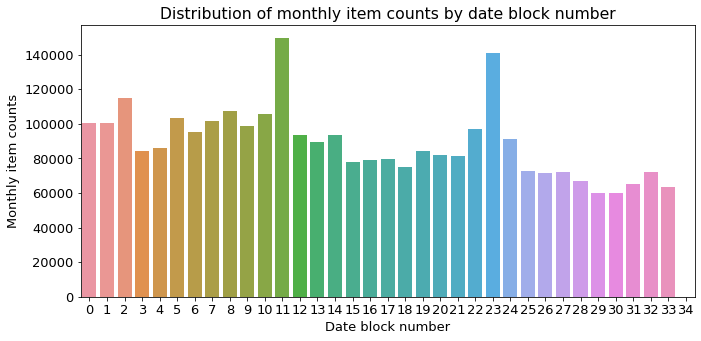

In [36]:
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

mpl.rc('font', size=13)
figure, ax = plt.subplots() 
figure.set_size_inches(11, 5)

# total montly item sales
group_month_sum = all_data.groupby('date_block_num',as_index=False).agg({'target': 'sum'})


sns.barplot(x='date_block_num', y='target', data=group_month_sum)
ax.set(title='Distribution of monthly item counts by date block number',
       xlabel='Date block number', 
       ylabel='Monthly item counts');

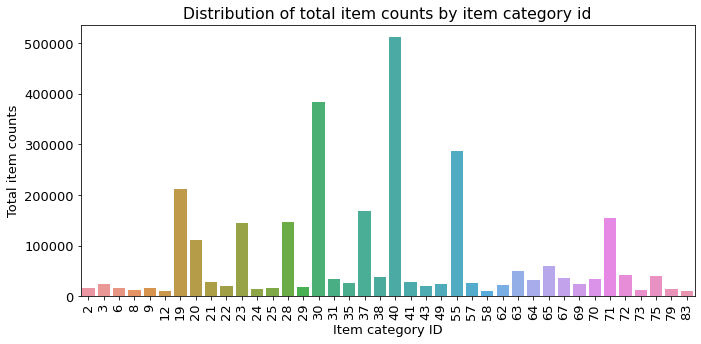

In [37]:
figure, ax= plt.subplots() 
figure.set_size_inches(11, 5)

# Total item sales by item_category_id
group_cat_sum = all_data.groupby('item_category_id').agg({'target': 'sum'})
group_cat_sum = group_cat_sum.reset_index()

# Extract only item categories with total sales > 10,000
group_cat_sum = group_cat_sum[group_cat_sum['target'] > 10000]

sns.barplot(x='item_category_id', y='target', data=group_cat_sum)
ax.set(title='Distribution of total item counts by item category id',
       xlabel='Item category ID', 
       ylabel='Total item counts')
ax.tick_params(axis='x', labelrotation=90) # Rotate X label

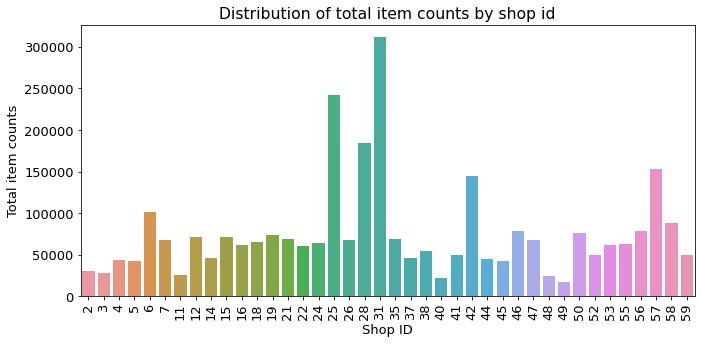

In [38]:
figure, ax= plt.subplots() 
figure.set_size_inches(11, 5)

# Total item sales by shop_id
group_shop_sum = all_data.groupby('shop_id').agg({'target': 'sum'})
group_shop_sum = group_shop_sum.reset_index()

group_shop_sum = group_shop_sum[group_shop_sum['target'] > 10000]

sns.barplot(x='shop_id', y='target', data=group_shop_sum)
ax.set(title='Distribution of total item counts by shop id',
       xlabel='Shop ID', 
       ylabel='Total item counts')
ax.tick_params(axis='x', labelrotation=90)

## Advanced Feature Engineering

#### 1.Mean Encodings

In [36]:
all_data['item_id_mean_sales'] = all_data.groupby(['date_block_num','item_id'])['target'].transform('mean')

all_data['item_id_city_mean_sales'] = all_data.groupby(['date_block_num','item_id','city'])['target'].transform('mean')

all_data['shop_id_item_category_id_mean_sales'] = all_data.groupby(['date_block_num','shop_id','item_category_id'])['target'].transform('mean')

In [37]:
downcast(all_data, False)
item_mean_feats= ['item_id_mean_sales','item_id_city_mean_sales']
shop_mean_features = ['shop_id_item_category_id_mean_sales']

#### 2.Lag Features

In [38]:
lag_features_to_clip = []

def add_lag_features(df, lag_features_to_clip, index_cols, 
                     lag_feature,clip=False):
    # Copy only the part of the DataFrame needed to create the lag features
    df_temp = df[index_cols + [lag_feature]].copy() 
    shift_range = [1, 2, 3]
    
    # Create lag features
    for month_shift in tqdm(shift_range):
        # Lag featrue name
        lag_feature_name = lag_feature +'_lag' + str(month_shift)
        # Set df_temp column name
        df_temp.columns = index_cols + [lag_feature_name]
        # Add 1 to date_block_num feature in df_temp
        df_temp['date_block_num'] += month_shift
        # Merge df with df_temp based on idx_feature
        df = df.merge(df_temp.drop_duplicates(), 
                      on=index_cols, 
                      how='left')
        # Replace NaN with 0
        df[lag_feature_name] = df[lag_feature_name].fillna(0)
        # Add lag features to lag_features_to_clip to clip between 0 and 20
        if clip: 
            lag_features_to_clip.append(lag_feature_name)
    
    # Date downcasting
    df = downcast(df, False)
    # Garbage collection
    del df_temp
    gc.collect()
    
    return df, lag_features_to_clip

In [39]:
index_cols = ['date_block_num', 'shop_id', 'item_id']
all_data, lag_features_to_clip = add_lag_features(df=all_data, 
                                                  lag_features_to_clip=lag_features_to_clip,
                                                  index_cols=index_cols,
                                                  lag_feature='target',
                                                 clip = True)

In [40]:
# Create 3 month lag features of item_count feature based on idx_features
all_data, lag_features_to_clip = add_lag_features(df=all_data, 
                                                  lag_features_to_clip=lag_features_to_clip,
                                                  index_cols=index_cols,
                                                  lag_feature='item_count')

# Create 3 month lag features of item_price_mean feature based on idx_features
all_data, lag_features_to_clip = add_lag_features(df=all_data, 
                                                  lag_features_to_clip=lag_features_to_clip,
                                                  index_cols=index_cols,
                                                  lag_feature='item_price_mean')

In [41]:
# Create lag features for mean encodings
for mean_feature in item_mean_feats:
    all_data, lag_features_to_clip = add_lag_features(df=all_data, 
                                                      lag_features_to_clip=lag_features_to_clip, 
                                                      index_cols=index_cols, 
                                                      lag_feature=mean_feature)
    
all_data = all_data.drop(item_mean_feats, axis=1)

In [42]:
# Create lag features by shop_mean_features element based on ['date_block_num', 'shop_id', 'item_category_id']
for shop_mean_feature in shop_mean_features:
    all_data, lag_features_to_clip = add_lag_features(df=all_data,
                                                      lag_features_to_clip=lag_features_to_clip, 
                                                      index_cols=['date_block_num', 'shop_id', 'item_category_id'], 
                                                      lag_feature=shop_mean_feature)
# Remove features in shop_mean_features
all_data = all_data.drop(shop_mean_features, axis=1)

In [43]:
all_data = all_data.drop(all_data[all_data['date_block_num'] < 3].index)

all_data['target_lag_mean'] = all_data[['target_lag1',
                                         'target_lag2', 
                                         'target_lag3']].mean(axis=1)

all_data[lag_features_to_clip + ['target','target_lag_mean']] = all_data[lag_features_to_clip +['target','target_lag_mean']].clip(0, 20)

Clip Values into 0 - 20 range

In [44]:
all_data['lag_grad1'] = all_data['target_lag1']/all_data['target_lag2']
all_data['lag_grad1'] = all_data['lag_grad1'].replace([np.inf, -np.inf], 
                                                        np.nan).fillna(0)

all_data['lag_grad2'] = all_data['target_lag2']/all_data['target_lag3']
all_data['lag_grad2'] = all_data['lag_grad2'].replace([np.inf, -np.inf], 
                                                        np.nan).fillna(0)

In [45]:
all_data['brand_new'] = all_data['first_sale_date'] == all_data['date_block_num']

all_data['duration_after_first_sale'] = all_data['date_block_num'] - all_data['first_sale_date']
all_data = all_data.drop('first_sale_date', axis=1)

all_data['month'] = all_data['date_block_num']%12

# Remove item_price_mean, item_count features
all_data = all_data.drop(['item_price_mean','item_count'], axis=1)
all_data = downcast(all_data, False)

In [46]:
all_data.columns

Index(['date_block_num', 'shop_id', 'item_id', 'target', 'city',
       'item_category_id', 'cat_name', 'target_lag1', 'target_lag2',
       'target_lag3', 'item_count_lag1', 'item_count_lag2', 'item_count_lag3',
       'item_price_mean_lag1', 'item_price_mean_lag2', 'item_price_mean_lag3',
       'item_id_mean_sales_lag1', 'item_id_mean_sales_lag2',
       'item_id_mean_sales_lag3', 'item_id_city_mean_sales_lag1',
       'item_id_city_mean_sales_lag2', 'item_id_city_mean_sales_lag3',
       'shop_id_item_category_id_mean_sales_lag1',
       'shop_id_item_category_id_mean_sales_lag2',
       'shop_id_item_category_id_mean_sales_lag3', 'target_lag_mean',
       'lag_grad1', 'lag_grad2', 'brand_new', 'duration_after_first_sale',
       'month'],
      dtype='object')

In [47]:
dates = all_data['date_block_num']
dates_train = dates[dates <  33]
dates_valid  = dates[dates == 33]
dates_test  = dates[dates == 34]

## Train/test split

In [48]:
X_train = all_data[all_data['date_block_num'] < 33]
X_train = X_train.drop(['target'], axis=1)
# Valid data (Features)
X_valid = all_data[all_data['date_block_num'] == 33]
X_valid = X_valid.drop(['target'], axis=1)
# Test data (Features)
X_test = all_data[all_data['date_block_num'] == 34]
X_test = X_test.drop(['target'], axis=1)

# Train data (Target values)
y_train = all_data[all_data['date_block_num'] < 33]['target'].values
# Valid data (Target values)
y_valid = all_data[all_data['date_block_num'] == 33]['target'].values

# Garbage collection
#del all_data
gc.collect();

In [49]:
print(" Train Shape: {}\n".format(X_train.shape),
      "Validation Shape: {}\n".format(X_valid.shape),
     "Test Shape: {}".format(X_test.shape),)

 Train Shape: (7593847, 30)
 Validation Shape: (221718, 30)
 Test Shape: (214200, 30)


## Fitting a Model

In [58]:
#Categorical Features
cat_features = ['shop_id', 'city', 'item_category_id', 'cat_name','month']

In [65]:
model = CatBoostRegressor(iterations=1000,
                 task_type='GPU',
                 eval_metric='RMSE',
                 thread_count=1,
                 min_data_in_leaf = 2**8,
                 bagging_temperature=0.75,
                 learning_rate=0.005,
                 objective='RMSE',
                 random_state = 42 ,
                boosting_type ='Plain',
                max_ctr_complexity=1,
                gpu_cat_features_storage='CpuPinnedMemory'
                 )

In [66]:
model.get_params()

{'iterations': 1000,
 'learning_rate': 0.005,
 'loss_function': 'RMSE',
 'thread_count': 1,
 'max_ctr_complexity': 1,
 'eval_metric': 'RMSE',
 'bagging_temperature': 0.75,
 'boosting_type': 'Plain',
 'task_type': 'GPU',
 'random_state': 42,
 'objective': 'RMSE',
 'gpu_cat_features_storage': 'CpuPinnedMemory',
 'min_data_in_leaf': 256}

In [67]:
model.fit(X_train,y_train,
          early_stopping_rounds=150,
         eval_set=(X_valid,y_valid),
         cat_features=cat_features,
         verbose_eval= 100)

0:	learn: 1.2310409	test: 1.0799619	best: 1.0799619 (0)	total: 138ms	remaining: 2m 17s
100:	learn: 1.0685091	test: 0.9485754	best: 0.9485754 (100)	total: 12.1s	remaining: 1m 47s
200:	learn: 0.9888946	test: 0.8853491	best: 0.8853491 (200)	total: 24s	remaining: 1m 35s
300:	learn: 0.9489161	test: 0.8567925	best: 0.8567925 (300)	total: 35.9s	remaining: 1m 23s
400:	learn: 0.9279001	test: 0.8417301	best: 0.8417301 (400)	total: 48.2s	remaining: 1m 11s
500:	learn: 0.9155032	test: 0.8325170	best: 0.8325170 (500)	total: 1m	remaining: 1m
600:	learn: 0.9078688	test: 0.8269678	best: 0.8269678 (600)	total: 1m 13s	remaining: 48.6s
700:	learn: 0.9028846	test: 0.8231909	best: 0.8231909 (700)	total: 1m 25s	remaining: 36.6s
800:	learn: 0.8991267	test: 0.8202736	best: 0.8202736 (800)	total: 1m 38s	remaining: 24.5s
900:	learn: 0.8960579	test: 0.8177501	best: 0.8177501 (900)	total: 1m 51s	remaining: 12.2s
999:	learn: 0.8936017	test: 0.8159992	best: 0.8159992 (999)	total: 2m 3s	remaining: 0us
bestTest = 0.81

In [68]:
y_pred = model.predict(X_test.clip(0,20)).clip(0,20)

In [69]:
sub['item_cnt_month'] = y_pred
sub.to_csv('cat_pred.csv',index=False)

### LightGBM

In [50]:
# lgb hyper-parameters
params = {'metric': 'rmse',
          'num_leaves': 255,
          'learning_rate': 0.005,
          'feature_fraction': 0.75,
          'bagging_fraction': 0.75,
          'bagging_freq': 5,
          'force_col_wise' : True,
          'random_state': 10}

cat_features = ['shop_id', 'city', 'item_category_id', 'cat_name', 'month']

# lgb train and valid dataset
dtrain = lgb.Dataset(X_train, y_train)
dvalid = lgb.Dataset(X_valid, y_valid)
 
# Train LightGBM model
lgb_model = lgb.train(params=params,
                      train_set=dtrain,
                      num_boost_round=1500,
                      valid_sets=(dtrain, dvalid),
                      early_stopping_rounds=150,
                      categorical_feature=cat_features,
                      verbose_eval=100)      

C:\Users\Elbrolosy\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['cat_name', 'city', 'item_category_id', 'month', 'shop_id']
  _log_warning('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Info] Total Bins 3953
[LightGBM] [Info] Number of data points in the train set: 7593847, number of used features: 30
[LightGBM] [Info] Start training from score 0.307756


C:\Users\Elbrolosy\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\Elbrolosy\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 150 rounds
[100]	training's rmse: 1.01924	valid_1's rmse: 0.913885
[200]	training's rmse: 0.914524	valid_1's rmse: 0.841624
[300]	training's rmse: 0.862191	valid_1's rmse: 0.812862
[400]	training's rmse: 0.83338	valid_1's rmse: 0.801447
[500]	training's rmse: 0.814076	valid_1's rmse: 0.797531
[600]	training's rmse: 0.800453	valid_1's rmse: 0.79689
[700]	training's rmse: 0.790068	valid_1's rmse: 0.796336
[800]	training's rmse: 0.781746	valid_1's rmse: 0.795874
[900]	training's rmse: 0.774625	valid_1's rmse: 0.795648
[1000]	training's rmse: 0.768645	valid_1's rmse: 0.795829
Early stopping, best iteration is:
[897]	training's rmse: 0.774772	valid_1's rmse: 0.795568


LightGBM works Better than CatBoost

In [51]:
preds = lgb_model.predict(X_test).clip(0,20)

sub['item_cnt_month'] = preds
sub.to_csv('pred_lgb.csv', index=False)

Save Model 

In [52]:
lgb_model.save_model('lgbr_base.txt')

Uncomment next cell to Load Model 

In [53]:
#Load Model
#lgb_model = lgb.Booster(model_file='lgbr_base.txt')

### Neural Network

In [54]:
from keras.models import Sequential
from keras.layers import Dense ,Dropout,BatchNormalization
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor


def baseline_model():
    # create model
    model = Sequential()
    
    
    
    model.add(Dense(16, input_dim=30, activation='relu'))
    
    
    model.add(Dense(8, input_dim=30, activation='relu'))
    
    
    model.add(Dense(1))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

estimator = KerasRegressor(build_fn=baseline_model, epochs=15, batch_size=64, verbose=1)
history=estimator.fit(X_train,y_train)
prediction = estimator.predict(X_valid)

Epoch 1/15
118654/118654 [==============================] - 59s 491us/step - loss: 11341.6517
Epoch 2/15
118654/118654 [==============================] - 58s 492us/step - loss: 1.0683
Epoch 3/15
118654/118654 [==============================] - 58s 490us/step - loss: 0.9599
Epoch 4/15
118654/118654 [==============================] - 58s 487us/step - loss: 0.9243
Epoch 5/15
118654/118654 [==============================] - 59s 495us/step - loss: 0.9097
Epoch 6/15
118654/118654 [==============================] - 58s 490us/step - loss: 0.9053
Epoch 7/15
118654/118654 [==============================] - 57s 480us/step - loss: 0.8943
Epoch 8/15
118654/118654 [==============================] - 57s 481us/step - loss: 0.8935
Epoch 9/15
118654/118654 [==============================] - 57s 479us/step - loss: 0.8941
Epoch 10/15
118654/118654 [==============================] - 57s 478us/step - loss: 0.8932
Epoch 11/15
118654/118654 [==============================] - 57s 479us/step - loss: 0.8799
Epoc

Model Load/Save

In [55]:
estimator.model.save('saved_model.h5')
#estimator.model = load_model('hh.h5') #Uncomment To load

### Ensembling

To ensemble we will use Two models Lightgbm and Neural Network and a linear mix of their prediction

let's first eval needed parameters for the mix on the valid set

In [56]:
pred_lgb_val = lgb_model.predict(X_valid).clip(0,20)
#pred_lr_val = lr.predict(X_valid).clip(0,20)
pred_nn_val = estimator.predict(X_valid).clip(0,20)

3465/3465 [==============================] - 1s 339us/step


Concatente first predictions and use it for prediction in level 2

In [57]:
X_test_level2 = np.c_[pred_lgb_val, pred_nn_val] 

In [58]:
dates_train_level2 = dates_train[dates_train.isin([27, 28, 29, 30, 31, 32])]

# That is how we get target for the 2nd level dataset
y_train_level2 = y_train[dates_train.isin([27, 28, 29, 30, 31, 32])]

Second Level training 

In [59]:
# And here we create 2nd level feeature matrix, init it with zeros first
X_train_level2 = np.zeros([y_train_level2.shape[0], 2])

params = {'metric': 'rmse',
          'num_leaves': 255,
          'learning_rate': 0.005,
          'feature_fraction': 0.75,
          'bagging_fraction': 0.75,
          'bagging_freq': 5,
          'force_col_wise' : True,
          'random_state': 10}

nn = KerasRegressor(build_fn=baseline_model, epochs=3, batch_size=128, verbose=1)
history=nn.fit(X_train,y_train)

# Now fill `X_train_level2` with metafeatures
for cur_block_num in [27, 28, 29, 30, 31, 32]:
    
    print(cur_block_num)
     
    X_train_2 = all_data.loc[dates < cur_block_num]
    X_train_2 = X_train_2.drop('target',axis=1)
    X_test_2 = all_data.loc[dates == cur_block_num]
    X_test_2 = X_test_2.drop('target',axis=1)
    y_train_2 = all_data.loc[dates <  cur_block_num, 'target'].values
    y_test_2 = all_data.loc[dates == cur_block_num, 'target'].values
    
    nn.fit(X_train_2.values, y_train_2)
    pred_lr2 = nn.predict(X_test_2.values).clip(0,20)
    model = lgb.train(params, lgb.Dataset(X_train_2, label=y_train_2), 100)
    pred_lgb2 = model.predict(X_test_2.values).clip(0,20).clip(0,20)
    X_train_level2[dates_train_level2 == cur_block_num, 0] = pred_lr2
    X_train_level2[dates_train_level2 == cur_block_num, 1] = pred_lgb2



Epoch 1/3
59327/59327 [==============================] - 31s 514us/step - loss: 1879.1294
Epoch 2/3
59327/59327 [==============================] - 31s 520us/step - loss: 1.0670
Epoch 3/3
59327/59327 [==============================] - 836s 14ms/step - loss: 0.9459
27
Epoch 1/3
49360/49360 [==============================] - 27s 530us/step - loss: 817.6389
Epoch 2/3
49360/49360 [==============================] - 27s 550us/step - loss: 1.0531
Epoch 3/3
1730/1730 [==============================] - 1s 323us/step
[LightGBM] [Info] Total Bins 3866
[LightGBM] [Info] Number of data points in the train set: 6318009, number of used features: 30
[LightGBM] [Info] Start training from score 0.315602
28
Epoch 1/3
51090/51090 [==============================] - 27s 517us/step - loss: 23472.1255
Epoch 2/3
51090/51090 [==============================] - 27s 525us/step - loss: 1.5662
Epoch 3/3
1661/1661 [==============================] - 1s 326us/step
[LightGBM] [Info] Total Bins 3860
[LightGBM] [Info] Numb

next cell we validate to get best parameters for linear mix of two models

In [60]:
alphas_to_try = np.linspace(0, 1, 1001)

# YOUR CODE GOES HERE
r2_scores = np.array([r2_score(y_train_level2, np.dot(X_train_level2, [alpha, 1 - alpha])) for alpha in alphas_to_try])
best_alpha = alphas_to_try[r2_scores.argmax()] 
r2_train_simple_mix = r2_scores.max()

print('Best alpha: %f; Corresponding r2 score on train: %f' % (best_alpha, r2_train_simple_mix))

Best alpha: 0.000000; Corresponding r2 score on train: 0.279972


Level 2 Predictions on valid st

In [61]:
test_preds = best_alpha * pred_nn_val + (1 - best_alpha) * pred_lgb_val
r2_test_simple_mix = r2_score(y_valid, test_preds.clip(0,20))

print('Test R-squared for simple mix is %f' % r2_test_simple_mix)

Test R-squared for simple mix is 0.457714


Use inital Models to predict for the test set and mix their predictions

In [62]:
pred_lgb_test = lgb_model.predict(X_test).clip(0,20)
pred_nn_test = estimator.predict(X_test).clip(0,20)
test_preds = best_alpha * pred_nn_test + (1 - best_alpha) * pred_lgb_test

3347/3347 [==============================] - 1s 321us/step


Save and submit

In [63]:
sub['item_cnt_month'] = test_preds
sub.to_csv('ensembling.csv',index=False)